In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.metrics import precision_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
pd.set_option('max_columns', None)

# Data

In [60]:
#police shooting raw data
shooting_df = pd.read_csv(r'police_shootings_FIPS_all.csv')

In [61]:
# Aggregate Data
police_data_aggregated_df = pd.read_csv(r'police_data_aggregated.csv')

In [ ]:
#2020 CHS data
xls = pd.ExcelFile('2020 County Health Rankings Data - v2.xlsx')
rmd_2020_1 = pd.read_excel(xls, 'Ranked Measure Data', header=[0, 1])
amd_2020_1 = pd.read_excel(xls, 'Additional Measure Data', header=[0, 1])

In [5]:
#adds the column names together from double rows
amd_2020_1.columns = amd_2020_1.columns.map('|'.join).str.strip('|')
rmd_2020_1.columns = rmd_2020_1.columns.map('|'.join).str.strip('|')

In [6]:
#merge two components of rmd
CHS_2020 = pd.merge(rmd_2020_1, amd_2020_1, how = 'outer', on = ['Unnamed: 0_level_0|FIPS'])
CHS_2020 = CHS_2020.rename(columns={"Unnamed: 0_level_0|FIPS": "FIPS", "Unnamed: 1_level_0|State_x": "State","Unnamed: 2_level_0|County_x": "County"})
CHS_2020 = CHS_2020[CHS_2020.County.notna()]

In [7]:
#remove CI columns
cols2 = [c for c in CHS_2020.columns if (c.lower()[-3:]!= 'low')]# or  (c.lower()[-4:] != 'high')]
cols = [c for c in cols2 if (c.lower()[-4:] != 'high')]
CHS_2020_trim = CHS_2020[cols]

In [8]:
#groupby police aggregate data
police_2020 = police_data_aggregated_df.groupby(['FIPS','state'])['killed_males', 'killed_females',
       'killed_race_A', 'killed_race_B', 'killed_race_H', 'killed_race_N',
       'killed_race_O', 'killed_race_W', 'killed_race_NA',
       'killed_armed_blank', 'killed_armed_undetermined', 'killed_armed_yes',
       'killed_armed_no', 'killed_signs_of_mental_illness_yes',
       'killed_signs_of_mental_illness_no', 'killed_threat_level_attack',
       'killed_threat_level_other', 'killed_threat_level_undetermined',
       'killed_flee_blank', 'killed_flee_car', 'killed_flee_foot',
       'killed_flee_other', 'killed_flee_no', 'body_camera_yes',
       'body_camera_no', 'shootings_total'].sum().reset_index()

/Users/connor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [9]:
shooting_df['date_CL'] = shooting_df['date'].apply(lambda x: pd.to_datetime(x))

shooting_df['year'] = shooting_df['date_CL'].apply(lambda x: x.year)

police_shootings_year_df = shooting_df.groupby(['FIPS','year'])['id'].count().unstack().reset_index()

police_shootings_year_df.loc[police_shootings_year_df[2015] > 0, '2015_CL'] =1
police_shootings_year_df.loc[police_shootings_year_df[2016] > 0, '2016_CL'] =1
police_shootings_year_df.loc[police_shootings_year_df[2017] > 0, '2017_CL'] =1
police_shootings_year_df.loc[police_shootings_year_df[2018] > 0, '2018_CL'] =1
police_shootings_year_df.loc[police_shootings_year_df[2019] > 0, '2019_CL'] =1
police_shootings_year_df.loc[police_shootings_year_df[2020] > 0, '2020_CL'] =1

police_shootings_year_df['no_year_shootings'] = police_shootings_year_df[['2015_CL','2016_CL','2017_CL','2018_CL','2019_CL','2020_CL']].sum(axis=1)

In [10]:
# merge CHS and police data
shooting_CHR_2020 = pd.merge(CHS_2020_trim, police_2020, how = 'outer', left_on = ['FIPS'], right_on=['FIPS'])

#fill in na with 0
shooting_CHR_2020['shootings_total'] = shooting_CHR_2020['shootings_total'].fillna(0)

#add dummy
shooting_CHR_2020.loc[:, 'shootings_total_dummy'] = 0
shooting_CHR_2020.loc[shooting_CHR_2020['shootings_total']>0, 'shootings_total_dummy'] = 1
shooting_CHR_2020['police_shooting_rate'] = (shooting_CHR_2020['shootings_total']/shooting_CHR_2020['Demographics|Population'])*100000


#add number of years police shootings occurred
shooting_CHR_2020= pd.merge(shooting_CHR_2020,police_shootings_year_df[['FIPS','no_year_shootings']], left_on = 'FIPS', right_on ='FIPS', how='inner')

In [11]:
#this code creates regions, marks which FIPS have mulitple year shootings and which classes are adverse.
shooting_CHR_2020['metro_x'] = 0
shooting_CHR_2020['urban_x'] = 0
shooting_CHR_2020['rural_x'] = 0

shooting_CHR_2020.loc[shooting_CHR_2020['Demographics|Population'] > 1000000, 'metro_x'] = 1
shooting_CHR_2020.loc[(shooting_CHR_2020['Demographics|Population'] >= 155000)& \
                    (shooting_CHR_2020['Demographics|Population'] <= 1000000),'urban_x'] = 1
shooting_CHR_2020.loc[shooting_CHR_2020['Demographics|Population'] < 155000,'rural_x'] = 1


shooting_CHR_2020['two_more'] = 0
shooting_CHR_2020['three_more'] = 0
shooting_CHR_2020['four_more'] = 0
shooting_CHR_2020['five_more'] = 0
shooting_CHR_2020['six'] = 0

shooting_CHR_2020.loc[shooting_CHR_2020['no_year_shootings']>=2,'two_more'] = 1
shooting_CHR_2020.loc[shooting_CHR_2020['no_year_shootings']>=3,'three_more'] = 1
shooting_CHR_2020.loc[shooting_CHR_2020['no_year_shootings']>=4,'four_more'] = 1
shooting_CHR_2020.loc[shooting_CHR_2020['no_year_shootings']>=5,'five_more'] = 1
shooting_CHR_2020.loc[shooting_CHR_2020['no_year_shootings']==6,'six'] = 1


shooting_CHR_2020['adverse_class'] = 0
shooting_CHR_2020.loc[(shooting_CHR_2020['metro_x']==1) &(shooting_CHR_2020['six']==1) & (shooting_CHR_2020.police_shooting_rate > 2), 'adverse_class'] = 1
#shooting_CHR_2020.loc[(shooting_CHR_2020['urban_x']==1) & (shooting_CHR_2020['four_more']==1), 'adverse_class'] = 1
shooting_CHR_2020.loc[(shooting_CHR_2020['urban_x']==1) & (shooting_CHR_2020.police_shooting_rate > 2), 'adverse_class'] = 1
shooting_CHR_2020.loc[(shooting_CHR_2020['rural_x']==1) & (shooting_CHR_2020['two_more']==1), 'adverse_class'] = 1

In [12]:
#subset of data used
edit =['FIPS','Poor mental health days|Average Number of Mentally Unhealthy Days',
 'Adult smoking|% Smokers',
 'Adult obesity|% Adults with Obesity',
 'Excessive drinking|% Excessive Drinking',
 'Teen births|Teen Birth Rate',
 'Uninsured|% Uninsured',
 'Mental health providers|Mental Health Provider Rate',
 'High school graduation|High School Graduation Rate',
 'Some college|% Some College',
 'Unemployment|% Unemployed',
 'Children in poverty|% Children in Poverty',
 'Children in single-parent households|% Single-Parent Households',
 'Social associations|Social Association Rate',
 'Violent crime|Violent Crime Rate',
  'Life expectancy|Life Expectancy',
 'Child mortality|Child Mortality Rate',
 'Infant mortality|Infant Mortality Rate',

 'Frequent physical distress|% Frequent Physical Distress',
 'Frequent mental distress|% Frequent Mental Distress',
 'Drug overdose deaths|Drug Overdose Mortality Rate',
 #'Motor vehicle crash deaths|Motor Vehicle Mortality Rate',

 'Median household income|Median Household Income',
 #'Residential segregation - Black/White|Segregation index',
 #'Residential segregation - non-White/White|Segregation Index',
 'Homicides|Homicide Rate',

 'Suicides|Suicide Rate (Age-Adjusted)',
 'Suicides|Crude Rate',
 'Firearm fatalities|Firearm Fatalities Rate',
 'Juvenile arrests|Juvenile Arrest Rate',
 'Homeownership|% Homeowners',
'five_more',
 'four_more',
 'metro_x',
 'no_year_shootings',
 'rural_x',
 'six',
 'three_more',
 'two_more',
 'urban_x']

In [13]:
x_2020 = shooting_CHR_2020[edit]   
x_2020 = x_2020.drop([1371])

In [14]:
#partition y
y_2020= shooting_CHR_2020[['FIPS', 'state', 'killed_males', 'killed_females',
       'killed_race_A', 'killed_race_B', 'killed_race_H', 'killed_race_N',
       'killed_race_O', 'killed_race_W', 'killed_race_NA',
       'killed_armed_blank', 'killed_armed_undetermined', 'killed_armed_yes',
       'killed_armed_no', 'killed_signs_of_mental_illness_yes',
       'killed_signs_of_mental_illness_no', 'killed_threat_level_attack',
       'killed_threat_level_other', 'killed_threat_level_undetermined',
       'killed_flee_blank', 'killed_flee_car', 'killed_flee_foot',
       'killed_flee_other', 'killed_flee_no', 'body_camera_yes',
       'body_camera_no', 'shootings_total','State',
 'County', 'shootings_total_dummy','police_shooting_rate','metro_x',
'urban_x', 'rural_x','adverse_class']]

# Impute missing Data using KNN Imputer


In [15]:
# # Imputer missing Data
imputer = KNNImputer(n_neighbors = 2)
x_2020_impute = imputer.fit_transform(x_2020.to_numpy())

In [16]:
x_2020 = pd.DataFrame(x_2020_impute, columns= x_2020.columns )

# Adverse and Bucket Catogories

In [17]:
# 45 Metro areas: 31 have six of shootings 
# 361 urban areas: 163 have four or more years of shootings 
# 965 rural areas: 317 have 2 or more years of shootings

In [18]:
x_2020

,FIPS,Poor mental health days|Average Number of Mentally Unhealthy Days,Adult smoking|% Smokers,Adult obesity|% Adults with Obesity,Excessive drinking|% Excessive Drinking,Teen births|Teen Birth Rate,Uninsured|% Uninsured,Mental health providers|Mental Health Provider Rate,High school graduation|High School Graduation Rate,Some college|% Some College,Unemployment|% Unemployed,Children in poverty|% Children in Poverty,Children in single-parent households|% Single-Parent Households,Social associations|Social Association Rate,Violent crime|Violent Crime Rate,Life expectancy|Life Expectancy,Child mortality|Child Mortality Rate,Infant mortality|Infant Mortality Rate,Frequent physical distress|% Frequent Physical Distress,Frequent mental distress|% Frequent Mental Distress,Drug overdose deaths|Drug Overdose Mortality Rate,Median household income|Median Household Income,Homicides|Homicide Rate,Suicides|Suicide Rate (Age-Adjusted),Suicides|Crude Rate,Firearm fatalities|Firearm Fatalities Rate,Juvenile arrests|Juvenile Arrest Rate,Homeownership|% Homeowners,five_more,four_more,metro_x,no_year_shootings,rural_x,six,three_more,two_more,urban_x
0,1003.0,4.304056,17.489033,31.0,17.958310,27.880692,11.333404,96.32055,86.361577,67.371620,3.615382,13.9,24.139601,10.205617,203.660396,78.450258,47.381750,5.546701,12.480108,13.475336,13.610487,57588.0,3.008333,19.377511,19.845968,14.093514,26.192661,73.619343,0.0,1.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0
1,1005.0,5.185594,21.999985,41.7,12.844016,40.870815,12.242792,8.03826,81.410256,34.857649,5.171384,43.9,56.603426,7.518797,414.277861,75.341935,74.225274,7.971071,17.184898,16.586252,11.545424,34382.0,7.618260,12.836104,13.900473,17.761715,15.000000,61.397779,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,1015.0,4.816072,20.612560,38.5,13.842230,33.534617,11.929168,115.50881,92.368046,59.243989,4.652832,26.5,40.191945,14.469005,756.066544,73.039109,65.813091,8.026030,14.754401,15.191507,18.334420,45400.0,9.762922,19.843748,20.516316,26.427796,37.264957,69.473497,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0
3,1021.0,4.853244,20.188979,37.7,14.509375,46.808511,13.759706,52.09159,88.205980,39.905570,3.609571,23.3,34.885047,15.204121,507.810721,74.926751,59.180002,6.867406,14.590992,15.177100,12.106446,47547.0,6.497620,14.368798,14.543141,14.997614,15.208333,74.849263,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0
4,1029.0,4.867215,18.374466,37.3,14.462967,38.831729,13.344524,40.03470,98.029557,45.014164,4.248651,22.9,24.549483,8.053691,103.333333,74.766029,72.785501,6.009785,13.617816,14.924845,18.782883,46495.0,5.951480,13.586501,14.684484,14.684484,15.397471,75.654907,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366,56007.0,3.608805,16.958455,30.4,18.992295,37.651123,16.266158,260.50364,81.818182,59.076626,3.788852,15.9,28.357796,9.802000,235.512655,77.238529,42.372936,4.937659,10.425124,11.165779,28.327377,61773.0,1.640323,32.884011,31.045857,25.871548,6.666667,68.301530,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1367,56009.0,3.408725,15.381536,31.7,19.125321,35.500995,12.734666,212.60997,84.357542,55.644664,3.680169,12.1,18.670606,9.414150,364.715861,78.039398,39.654312,4.803762,10.208193,10.682162,13.604577,68162.0,2.013536,27.828271,25.724208,22.865963,5.625000,71.983791,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0
1368,56013.0,3.926392,19.399937,29.1,17.480509,46.561862,20.112342,227.66942,75.106383,62.105940,5.221309,22.1,37.872635,12.561867,160.596926,75.217716,63.720805,8.516866,11.407569,12.573390,14.216900,51204.0,12.026799,29.843408,27.917086,23.928931,7.272727,69.906019,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1369,56021.0,3.350290,17.042886,30.0,17.932010,30.210713,11.433545,407.16941,79.944802,70.104742,3.873579,12.8,28.934100,13.017788,206.189829,78.954468,56.631308,5.211874,9.825271,10.674627,11.169818,63839.0,3.827802,27.232524,26.996681,19.429429,10.792079,69.761862,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1

In [19]:
#split up x_2020 into three datasets
metro_x = x_2020[x_2020['metro_x']==1]
urban_x = x_2020[x_2020['urban_x']==1]
rural_x = x_2020[x_2020['rural_x']==1] 

metro_x.drop([ 'FIPS', 'no_year_shootings', 'metro_x', 'urban_x', 'rural_x', 'two_more', 'three_more', 'four_more','five_more','six'], axis=1, inplace=True)
urban_x.drop([ 'FIPS','no_year_shootings', 'metro_x', 'urban_x', 'rural_x', 'two_more', 'three_more', 'four_more','five_more','six'], axis=1, inplace=True)
rural_x.drop([ 'FIPS','no_year_shootings', 'metro_x', 'urban_x', 'rural_x', 'two_more', 'three_more', 'four_more','five_more','six'], axis=1, inplace=True)


/Users/connor/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
metro_y = y_2020[y_2020['metro_x']==1]
urban_y = y_2020[y_2020['urban_x']==1]
rural_y = y_2020[y_2020['rural_x']==1] 

In [21]:
print(metro_x.shape)
print(urban_x.shape)
print(rural_x.shape)

(45, 27)
(361, 27)
(965, 27)


In [22]:
# Create Quartiles dataset

rural_q = pd.DataFrame()
urban_q = pd.DataFrame()
metro_q = pd.DataFrame()
for i in rural_x.columns:
    rural_q[str(i)] = pd.qcut(rural_x[i], 4, labels=[1,2,3,4])
    urban_q[str(i)] = pd.qcut(urban_x[i], 4, labels=[1,2,3,4])
    metro_q[str(i)] = pd.qcut(metro_x[i], 4, labels=[1,2,3,4])

In [23]:
# Using Quartiles Dummies

rural_d = pd.get_dummies(rural_q, columns = rural_q.columns)
urban_d = pd.get_dummies(urban_q, columns = urban_q.columns)
metro_d = pd.get_dummies(metro_q, columns = metro_q.columns)



In [24]:
urban_y.police_shooting_rate.describe()

count    361.000000
mean       1.759957
std        1.371574
min        0.159186
25%        0.722162
50%        1.441471
75%        2.386198
max       11.341320
Name: police_shooting_rate, dtype: float64

# X,Y

In [25]:
#come up with quantile dummies and regular 

In [26]:
#URBAN

X = StandardScaler().fit_transform(urban_x)

y = urban_y.adverse_class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Multi-Collinearity

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 




# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = rural_x.columns


  
# calculating VIF for each feature 
vif_data["VIF_rural"] = [variance_inflation_factor(rural_x.values, i) for i in range(len(rural_x.columns))] 
vif_data["VIF_urban"] = [variance_inflation_factor(urban_x.values, i) for i in range(len(rural_x.columns))] 
vif_data["VIF_metro"] = [variance_inflation_factor(metro_x.values, i) for i in range(len(rural_x.columns))] 


not_colinear_rural = list(vif_data[vif_data['VIF_rural']<10]['feature'])
not_colinear_urban = list(vif_data[vif_data['VIF_urban']<10]['feature'])
not_colinear_metro = list(vif_data[vif_data['VIF_metro']<10]['feature'])
vif_data

,feature,VIF_rural,VIF_urban,VIF_metro
0,Poor mental health days|Average Number of Ment...,1867.132496,1677.309428,4124.155642
1,Adult smoking|% Smokers,140.735778,157.100027,448.306107
2,Adult obesity|% Adults with Obesity,64.391644,150.457020,354.858691
3,Excessive drinking|% Excessive Drinking,70.434400,90.462391,440.489479
4,Teen births|Teen Birth Rate,19.776006,34.629656,217.096312
5,Uninsured|% Uninsured,13.568639,19.863780,68.614700
6,Mental health providers|Mental Health Provider...,3.069783,8.309144,79.618848
7,High school graduation|High School Graduation ...,214.395371,451.562493,1795.292148
8,Some college|% Some College,79.745644,253.949056,1780.111418
9,Unemployment|% Unemployed,21.377927,17.094315,253.459504


# Lasso - Metro Total Shootings

In [28]:
from sklearn import linear_model


def lasso_func(X,y):
    X2 = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=.2, random_state=42)
    clf = linear_model.Lasso(alpha=.1)
    clf.fit(X_train, y_train)
    data =clf.coef_
    cols = list(X.columns)                    # metro_d or metro_
    df = pd.DataFrame([data], columns = cols)
    lasso_metro = df.T
    lasso_metro.columns = ['Variables']

    lasso_metro_trim = lasso_metro[(lasso_metro.Variables>0)|(lasso_metro.Variables<0)].sort_values('Variables')
    #lasso_metro_trim.iloc[lasso_metro_trim.Variables.abs().argsort()].to_csv('new_output/rural_dummy_rate_lasso(a=.3).csv')
    return lasso_metro_trim.sort_values('Variables')

In [29]:
#lasso for adverse class
lasso_urban = lasso_func(urban_x,urban_y.adverse_class)
print(lasso_urban.shape)
lasso_urban

(4, 1)


,Variables
High school graduation|High School Graduation Rate,-0.015499
Suicides|Suicide Rate (Age-Adjusted),0.043335
Firearm fatalities|Firearm Fatalities Rate,0.051426
Teen births|Teen Birth Rate,0.066719


In [30]:
#lasso for the y value shooting rate
lasso_urban = lasso_func(urban_x,urban_y.police_shooting_rate)
print(lasso_urban.shape)
lasso_urban

(8, 1)


,Variables
Homeownership|% Homeowners,-0.036614
Mental health providers|Mental Health Provider Rate,0.018367
Unemployment|% Unemployed,0.023506
Children in poverty|% Children in Poverty,0.035441
Firearm fatalities|Firearm Fatalities Rate,0.154445
Teen births|Teen Birth Rate,0.218898
Violent crime|Violent Crime Rate,0.221809
Suicides|Suicide Rate (Age-Adjusted),0.495201


In [31]:
#lasso for the y value shootings_total
lasso_urban = lasso_func(urban_x,urban_y.shootings_total)
print(lasso_urban.shape)
lasso_urban

(15, 1)


,Variables
High school graduation|High School Graduation Rate,-1.047367
Children in single-parent households|% Single-Parent Households,-0.943957
Social associations|Social Association Rate,-0.819098
Homeownership|% Homeowners,-0.756232
Adult obesity|% Adults with Obesity,-0.643531
Adult smoking|% Smokers,-0.601156
Excessive drinking|% Excessive Drinking,-0.598816
Juvenile arrests|Juvenile Arrest Rate,-0.188619
Mental health providers|Mental Health Provider Rate,0.002964
Frequent physical distress|% Frequent Physical Distress,0.031852


In [32]:
lists = lasso_urban[(lasso_urban.Variables>0)|(lasso_urban.Variables<0)].sort_values('Variables').index
print(len(list(set([i.split('_', 1)[0] for i in lists]))))

#The top X number of variables
list(set([i.split('_', 1)[0] for i in lists]))

15


['Teen births|Teen Birth Rate',
 'Violent crime|Violent Crime Rate',
 'High school graduation|High School Graduation Rate',
 'Excessive drinking|% Excessive Drinking',
 'Juvenile arrests|Juvenile Arrest Rate',
 'Mental health providers|Mental Health Provider Rate',
 'Drug overdose deaths|Drug Overdose Mortality Rate',
 'Children in single-parent households|% Single-Parent Households',
 'Suicides|Suicide Rate (Age-Adjusted)',
 'Homeownership|% Homeowners',
 'Homicides|Homicide Rate',
 'Social associations|Social Association Rate',
 'Adult obesity|% Adults with Obesity',
 'Frequent physical distress|% Frequent Physical Distress',
 'Adult smoking|% Smokers']

# Random Forest

In [33]:
#pip install imblearn
from imblearn.over_sampling import SMOTE

In [34]:
#RURAL/URBAN/METRO

#X

# Standardized X
#X = StandardScaler().fit_transform(rural_x)

#X = StandardScaler().fit_transform(rural_x)
X = StandardScaler().fit_transform(urban_x)
#X = StandardScaler().fit_transform(metro_x)

# Non-Standardized Quartile X
#X = rural_q[rural_cols]
#X = urban_q[urban_cols]
#X = metro_q[metro_cols]

# Non-Standardized Quartile Dummy X
# X = rural_d
#X = urban_d
#X = metro_d



# adverse class
#y = rural_y.adverse_class
y = urban_y.adverse_class
#y = metro_y.adverse_class


# shootings total
#y = rural_y.shootings_total
#y = urban_y.shootings_total
#y = metro_y.shootings_total


#use oversample to achieve good scores on models (metro and rural) (urban performs better without oversampling)
oversample = SMOTE(random_state = 12) #
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.35, random_state=42)

In [35]:
from sklearn import metrics

In [36]:

clf = RandomForestClassifier(max_depth= 9, random_state= 5)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

score = precision_score(y_test, y_pred, average='weighted')

score


# SCORE for updated values
# 0.45 rural 
# 0.72 urban
# 0.83 metro


0.8277964959568733

In [37]:

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.63      0.75        78
           1       0.74      0.95      0.83        87

    accuracy                           0.80       165
   macro avg       0.83      0.79      0.79       165
weighted avg       0.83      0.80      0.79       165



In [38]:
# test metrics
print("Confusion Matrix: ")
print(metrics.confusion_matrix(y_test, y_pred))
print("Classification Metrics: ")
print(metrics.classification_report(y_test, y_pred))

Confusion Matrix: 
[[49 29]
 [ 4 83]]
Classification Metrics: 
              precision    recall  f1-score   support

           0       0.92      0.63      0.75        78
           1       0.74      0.95      0.83        87

    accuracy                           0.80       165
   macro avg       0.83      0.79      0.79       165
weighted avg       0.83      0.80      0.79       165



In [39]:
features = urban_x.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

importances

array([0.02191163, 0.01901725, 0.02227593, 0.02632723, 0.09210677,
       0.03952983, 0.02412904, 0.04563724, 0.04898649, 0.02833176,
       0.02192795, 0.02599687, 0.02952887, 0.03117775, 0.02539096,
       0.02820671, 0.02395175, 0.03427347, 0.03260462, 0.03787438,
       0.03510524, 0.03540373, 0.07120724, 0.06266745, 0.08295002,
       0.02040122, 0.03307859])

In [40]:
features

Index(['Poor mental health days|Average Number of Mentally Unhealthy Days',
       'Adult smoking|% Smokers', 'Adult obesity|% Adults with Obesity',
       'Excessive drinking|% Excessive Drinking',
       'Teen births|Teen Birth Rate', 'Uninsured|% Uninsured',
       'Mental health providers|Mental Health Provider Rate',
       'High school graduation|High School Graduation Rate',
       'Some college|% Some College', 'Unemployment|% Unemployed',
       'Children in poverty|% Children in Poverty',
       'Children in single-parent households|% Single-Parent Households',
       'Social associations|Social Association Rate',
       'Violent crime|Violent Crime Rate', 'Life expectancy|Life Expectancy',
       'Child mortality|Child Mortality Rate',
       'Infant mortality|Infant Mortality Rate',
       'Frequent physical distress|% Frequent Physical Distress',
       'Frequent mental distress|% Frequent Mental Distress',
       'Drug overdose deaths|Drug Overdose Mortality Rate',
      

In [41]:
features_list = [i.split('|')[1] for i in features]
features_list[-4] = "Suicide Rate"
features_list

['Average Number of Mentally Unhealthy Days',
 '% Smokers',
 '% Adults with Obesity',
 '% Excessive Drinking',
 'Teen Birth Rate',
 '% Uninsured',
 'Mental Health Provider Rate',
 'High School Graduation Rate',
 '% Some College',
 '% Unemployed',
 '% Children in Poverty',
 '% Single-Parent Households',
 'Social Association Rate',
 'Violent Crime Rate',
 'Life Expectancy',
 'Child Mortality Rate',
 'Infant Mortality Rate',
 '% Frequent Physical Distress',
 '% Frequent Mental Distress',
 'Drug Overdose Mortality Rate',
 'Median Household Income',
 'Homicide Rate',
 'Suicide Rate (Age-Adjusted)',
 'Suicide Rate',
 'Firearm Fatalities Rate',
 'Juvenile Arrest Rate',
 '% Homeowners']

In [42]:
#features_list = [i.split('|')[1] for i in features]


df_viz = pd.DataFrame(importances,features_list)#.reset_index()
df_viz.columns = ['Relative Importances']
x = df_viz.sort_values('Relative Importances', ascending = False)
x.iloc[0:9]

,Relative Importances
Teen Birth Rate,0.092107
Firearm Fatalities Rate,0.082950
Suicide Rate (Age-Adjusted),0.071207
Suicide Rate,0.062667
% Some College,0.048986
High School Graduation Rate,0.045637
% Uninsured,0.039530
Drug Overdose Mortality Rate,0.037874
Homicide Rate,0.035404


Text(0.5, 0, 'Random Forest Feature Importance')

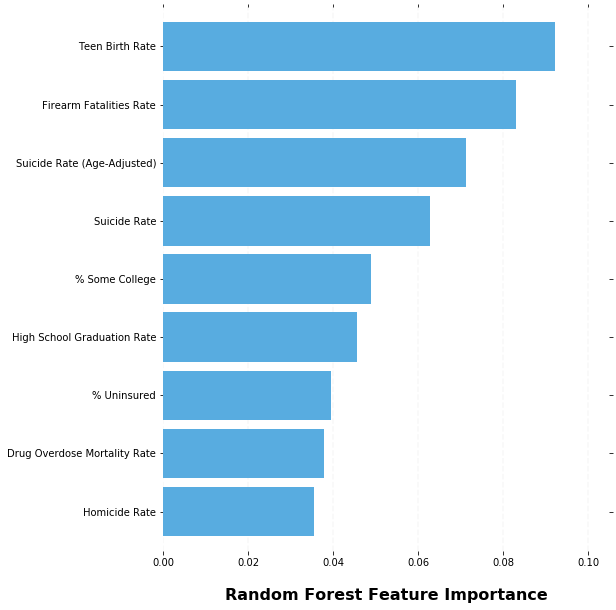

In [43]:
df_viz = pd.DataFrame(importances,features_list)#.reset_index()
df_viz.columns = ['Relative Importances']
x = df_viz.sort_values('Relative Importances', ascending = False)
x2 = x.iloc[0:9]
ax = x2.sort_values('Relative Importances', ascending = True).plot(kind='barh', figsize=(8, 10), color='#58ace0', zorder=2, width=0.85,legend=False)

  # Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

  # Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

  # Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

  # Set x-axis label
ax.set_xlabel("Random Forest Feature Importance", labelpad=20, weight='bold', size=16)
#plt.savefig('figs/rf_feature_importance_10.png')

  # Set y-axis label

Text(0.5, 0, 'Random Forest Feature Importance')

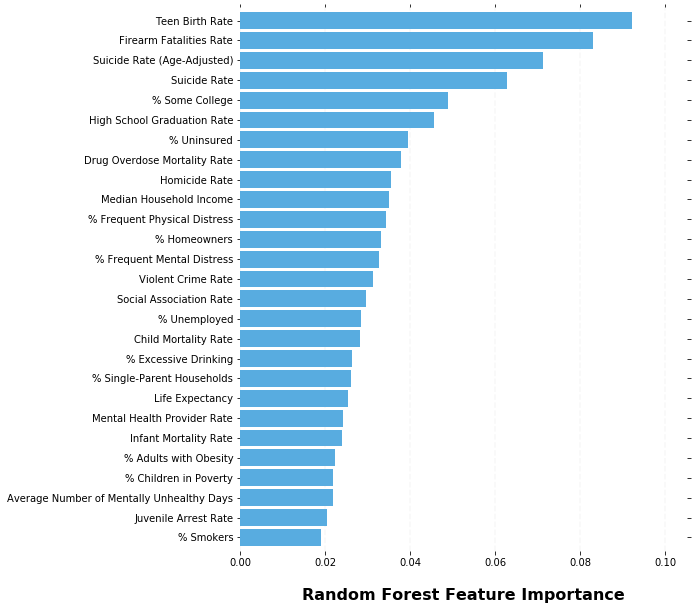

In [44]:
df_viz = pd.DataFrame(importances,features_list)#.reset_index()
df_viz.columns = ['Relative Importances']
x = df_viz.sort_values('Relative Importances', ascending = False)
ax = x.sort_values('Relative Importances', ascending = True).plot(kind='barh', figsize=(8, 10), color='#58ace0', zorder=2, width=0.85,legend=False)

  # Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

  # Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

  # Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

  # Set x-axis label
ax.set_xlabel("Random Forest Feature Importance", labelpad=20, weight='bold', size=16)
#plt.savefig('figs/rf_feature_importance_all.png')

  # Set y-axis label

# CART 

In [45]:
from matplotlib.pylab import rcParams
from sklearn import tree

def cart_function_tree(X,y):
    X2 = StandardScaler().fit_transform(X)
    decision_tree_total = DecisionTreeClassifier(random_state=0,criterion = 'gini')
    decision_tree_total = decision_tree_total.fit(X2, y)
    rcParams['figure.figsize'] = 80,50
    return tree.plot_tree(decision_tree_total,feature_names=X.columns ), decision_tree_total


[Text(2678.658932714617, 2613.4615384615386, 'Teen births|Teen Birth Rate <= 0.513\ngini = 0.454\nsamples = 361\nvalue = [235, 126]'),
 Text(1483.6844547563805, 2404.3846153846152, 'Suicides|Crude Rate <= 0.248\ngini = 0.343\nsamples = 255\nvalue = [199, 56]'),
 Text(693.9396751740139, 2195.3076923076924, 'Adult obesity|% Adults with Obesity <= 1.163\ngini = 0.161\nsamples = 170\nvalue = [155, 15]'),
 Text(445.36426914153134, 1986.2307692307693, 'Unemployment|% Unemployed <= 1.42\ngini = 0.121\nsamples = 155\nvalue = [145, 10]'),
 Text(362.5058004640371, 1777.1538461538462, 'High school graduation|High School Graduation Rate <= -1.336\ngini = 0.11\nsamples = 154\nvalue = [145, 9]'),
 Text(196.78886310904872, 1568.076923076923, 'Teen births|Teen Birth Rate <= -0.251\ngini = 0.444\nsamples = 6\nvalue = [4, 2]'),
 Text(113.93039443155453, 1359.0, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(279.6473317865429, 1359.0, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(528.2227378190255

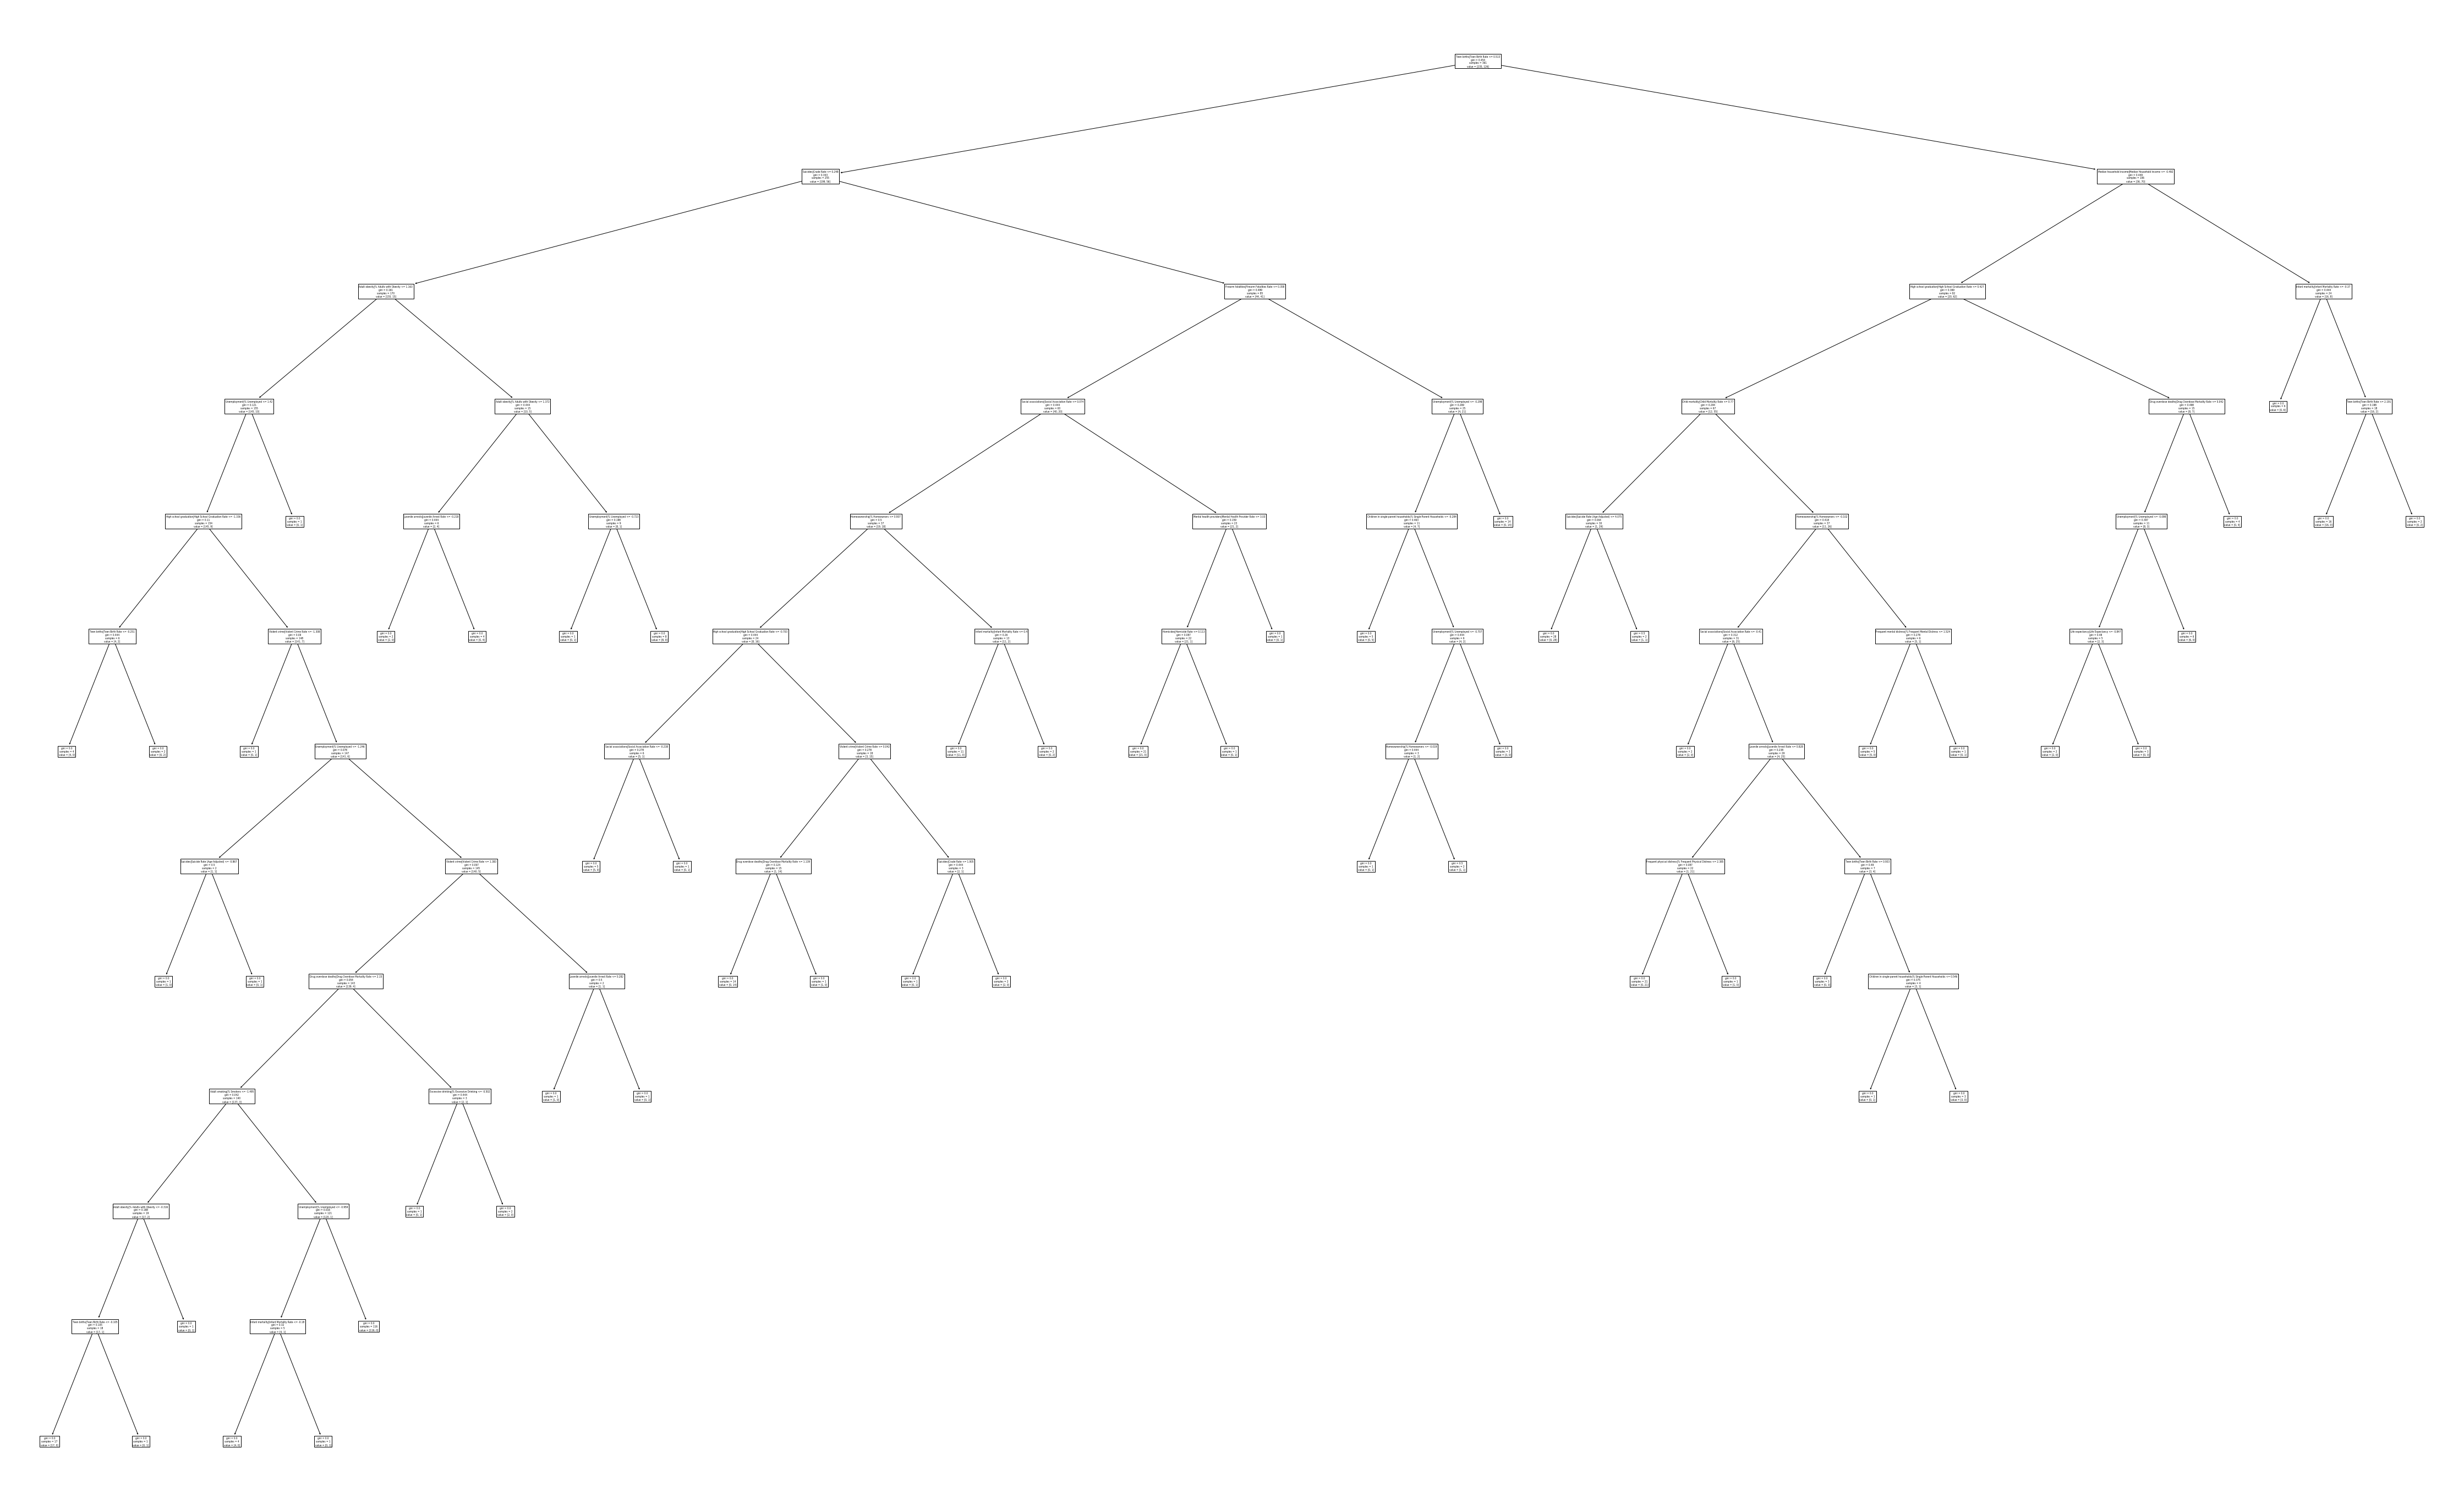

In [46]:
viz,decision_tree_total =  cart_function_tree(urban_x, urban_y.adverse_class)
viz

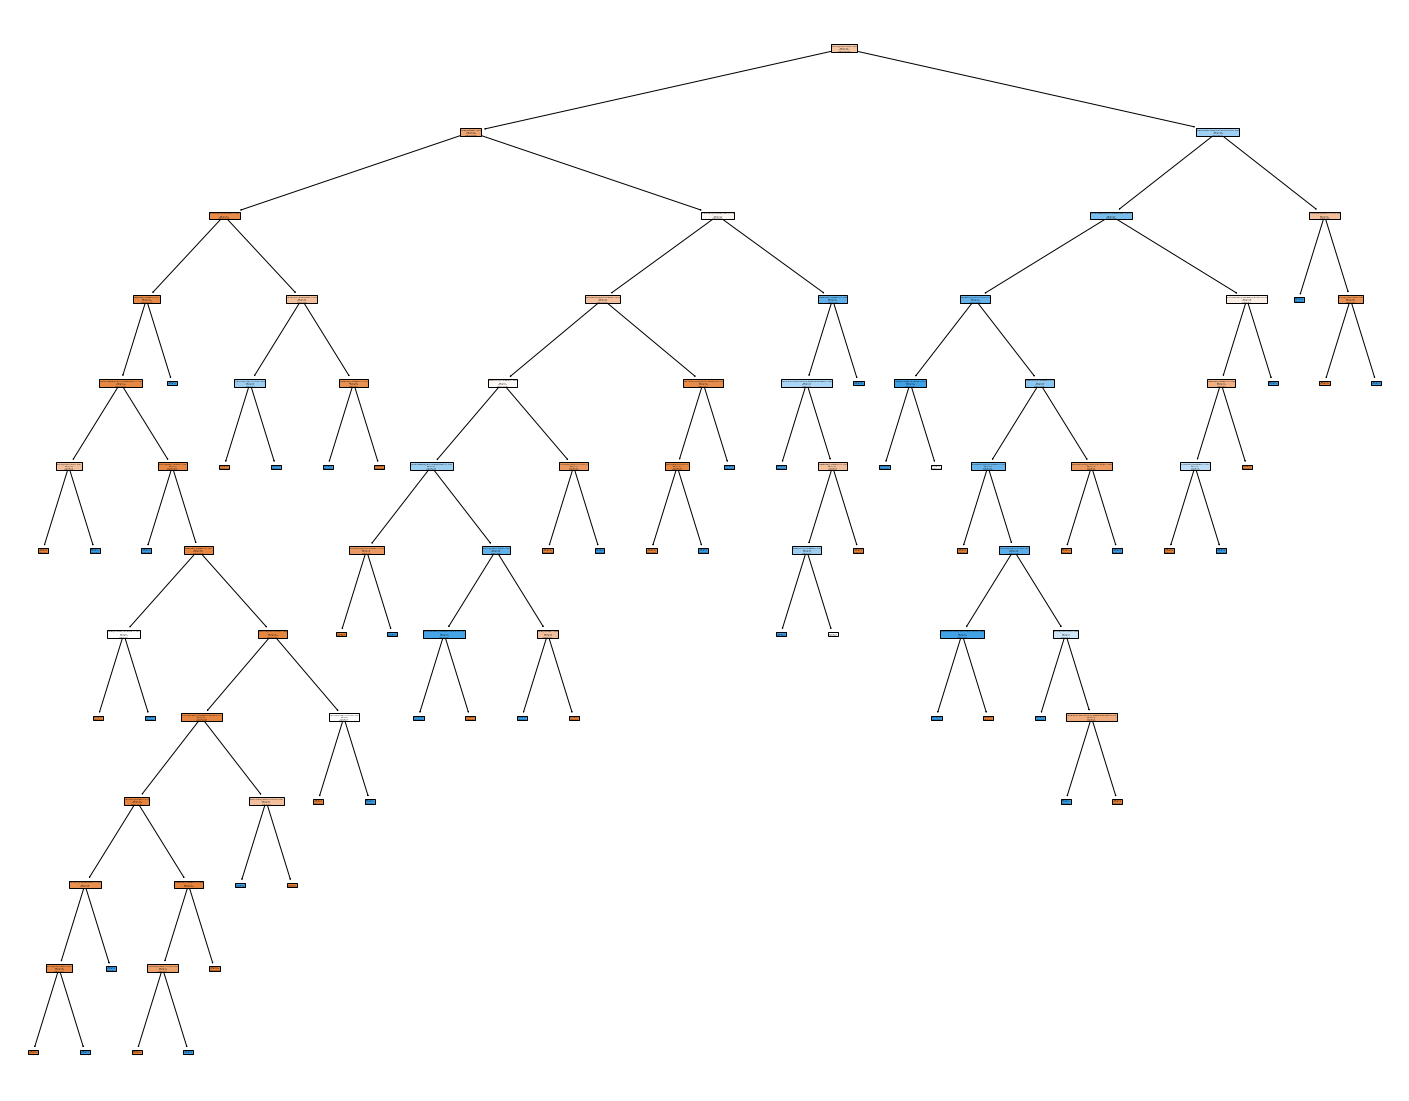

In [47]:
fig = plt.figure(figsize=(25,20))
graph = tree.plot_tree(decision_tree_total, 
                   feature_names=urban_x.columns,  
                   filled=True)

In [48]:


#use oversample to achieve good scores on models (metro and rural) (urban performs better without oversampling)

X = StandardScaler().fit_transform(urban_x)
y = urban_y.adverse_class

oversample = SMOTE(random_state = 2) #
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.35, random_state=42)

decision_tree = DecisionTreeClassifier(random_state=0,criterion = 'gini')
decision_tree = decision_tree.fit(X_train, y_train, )

y_pred = decision_tree.predict(X_test)

score = precision_score(y_test, y_pred, average='weighted')

score


0.6747749774977497

In [49]:
r = export_text(decision_tree, feature_names=list(metro_x.columns))
print(r)

|--- Teen births|Teen Birth Rate <= -0.04
|   |--- Suicides|Crude Rate <= 0.11
|   |   |--- Median household income|Median Household Income <= -1.09
|   |   |   |--- class: 1
|   |   |--- Median household income|Median Household Income >  -1.09
|   |   |   |--- Unemployment|% Unemployed <= -1.24
|   |   |   |   |--- class: 1
|   |   |   |--- Unemployment|% Unemployed >  -1.24
|   |   |   |   |--- Violent crime|Violent Crime Rate <= -1.29
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Violent crime|Violent Crime Rate >  -1.29
|   |   |   |   |   |--- Violent crime|Violent Crime Rate <= 0.25
|   |   |   |   |   |   |--- Excessive drinking|% Excessive Drinking <= -1.66
|   |   |   |   |   |   |   |--- Juvenile arrests|Juvenile Arrest Rate <= 0.43
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- Juvenile arrests|Juvenile Arrest Rate >  0.43
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- Excessive drinking|% Excessive Drinkin

# Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression

def logit(X,y):
    X2 = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred,y_test


In [51]:
 y_pred,y_test = logit(urban_x, urban_y.adverse_class)

# test metrics
print("Confusion Matrix: ")
print(metrics.confusion_matrix(y_test, np.where(y_pred>.5, 1,0)))
print("Classification Metrics: ")
print(metrics.classification_report(y_test, np.where(y_pred>.5, 1,0)))

Confusion Matrix: 
[[41  8]
 [13 11]]
Classification Metrics: 
              precision    recall  f1-score   support

           0       0.76      0.84      0.80        49
           1       0.58      0.46      0.51        24

    accuracy                           0.71        73
   macro avg       0.67      0.65      0.65        73
weighted avg       0.70      0.71      0.70        73



/Users/connor/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Linear Regression

In [52]:
import statsmodels.api as sm

In [53]:
import statsmodels.api as sm

def linear_regression(X,y):
    X2 = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=.2, random_state=42)
    model = sm.OLS(y_train, X_train)
    results = model.fit()
    return results.summary(xname=list(X.columns))

In [54]:
# linear regression for all urban_x columns 
linear_regression(urban_x, urban_y.adverse_class)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          adverse_class   R-squared (uncentered):                   0.267
Model:                            OLS   Adj. R-squared (uncentered):              0.191
Method:                 Least Squares   F-statistic:                              3.522
Date:                Mon, 07 Dec 2020   Prob (F-statistic):                    6.87e-08
Time:                        17:55:52   Log-Likelihood:                         -214.45
No. Observations:                 288   AIC:                                      482.9
Df Residuals:                     261   BIC:                                      581.8
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Poor mental health days|Average Number of Mentally Unhealthy Days    -0.1520      0.143     -1.060      0.290      -0.434       0.130
Adult smoking|% Smokers                                              -0.0702      0.074     -0.944      0.346      -0.217       0.076
Adult obesity|% Adults with Obesity                                  -0.0051      0.063     -0.081      0.935      -0.129       0.118
Excessive drinking|% Excessive Drinking                              -0.0178      0.043     -0.417      0.677      -0.102       0.066
Teen births|Teen Birth Rate                                           0.0428      0.081      0.528      0.598      -0.117       0.202
Uninsured|% Uninsured                                                 0.0099      0.059      0.167      0.868      -0.107       0.127
Mental health providers|Mental Health Provider Rate                   0.0415      0.046      0.893      0.372      -0.050       0.133
High school graduation|High School Graduation Rate                   -0.0479      0.048     -1.002      0.317      -0.142       0.046
Some college|% Some College                                          -0.0129      0.063     -0.203      0.839      -0.138       0.112
Unemployment|% Unemployed                                             0.0628      0.042      1.481      0.140      -0.021       0.146
Children in poverty|% Children in Poverty                             0.0274      0.099      0.276      0.783      -0.168       0.223
Children in single-parent households|% Single-Parent Households      -0.1590      0.099     -1.603      0.110      -0.354       0.036
Social associations|Social Association Rate                           0.0186      0.042      0.440      0.660      -0.065       0.102
Violent crime|Violent Crime Rate                                      0.0082      0.063      0.130      0.896      -0.115       0.132
Life expectancy|Life Expectancy                                      -0.1338      0.085     -1.567      0.118      -0.302       0.034
Child mortality|Child Mortality Rate                                 -0.0677      0.115     -0.590      0.556      -0.294       0.158
Infant mortality|Infant Mortality Rate                               -0.0093      0.091     -0.102      0.919      -0.189       0.170
Frequent physical distress|% Frequent Physical Distress               0.0086      0.113      0.076      0.939      -0.215       0.232
Frequent mental distress|% Frequent Mental Distress                   0.1968      0.200      0.985      0.325      -0.196       0.590
Drug overdose deaths|Drug Overdose M

# Classifiers

In [55]:
# This function takes in different 
from sklearn.metrics import recall_score


def precision_measure(X_raw,y_raw,PCA, catogory):
    X = X_raw.copy()
    
    if PCA == True:
        X = StandardScaler().fit_transform(X)
        pca = PCA(n_components=2) # create a PCA object
        pca.fit(X) # do the math
        X = pca.transform(X) # get PCA coordinates for scaled_data
        
    else: 
#         print('test')
        X = X
    
    y = y_raw.adverse_class
    
    oversample = SMOTE(random_state = 3) #     ADDED SMOTE
    X, y = oversample.fit_resample(X, y)

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    
    dict_accuracy = dict()
    dict_precision = dict()
    dict_sensitivity = dict()
    dict_specificity  = dict()
    names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
             "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
             "Naive Bayes", "QDA"]

    classifiers = [
        KNeighborsClassifier(3),
        SVC(kernel="linear", C=0.025, random_state= 5),
        SVC(gamma=2, C=1, random_state= 5),
        GaussianProcessClassifier(1.0 * RBF(1.0), random_state= 5),
        DecisionTreeClassifier(max_depth=5, random_state= 5),
        #RandomForestClassifier(max_depth=12, n_estimators=10, max_features=1),
        RandomForestClassifier(max_depth= 9, random_state= 5),
        MLPClassifier(alpha=3, max_iter=1000, random_state= 4),
        AdaBoostClassifier(random_state= 5),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()]

    # i = 1
    for name, clf in zip(names, classifiers):
    #     ax = plt.subplot(1, len(classifiers) + 1, i)
    
        #accuracy
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        dict_accuracy[name] = score
        #print(score)
        
        
        #score is now weighted precision
        y_pred = clf.predict(X_test)
        
        
        #print(metrics.confusion_matrix(y_test, y_pred))
        #precision_score_num = precision_score(y_test, y_pred, average='binary')
        #print(precision_score_num)
        #dict_precision[name] = precision_score_num
        
        C  = metrics.confusion_matrix(y_test, y_pred)

        TN = C[0][0]
        FN = C[1][0]
        TP = C[1][1]
        FP = C[0][1]

        dict_accuracy[name] = (TP+TN)/(TP+TN+FP+FN)



        dict_sensitivity[name] = (TP)/(TP+FN)


        dict_specificity[name] = (TN)/(TN+FP)


        dict_precision[name] = (TP)/(TP+FP)

    #print(dict_accuracy)
    
    df_accuracy = pd.DataFrame.from_dict(dict_accuracy, orient='index',columns=['Accuracy'])
    df_sensitivity = pd.DataFrame.from_dict(dict_sensitivity, orient='index',columns=['Sensitivity'])
    df_specificity = pd.DataFrame.from_dict(dict_specificity, orient='index',columns=['Specificity'])
    df_precision = pd.DataFrame.from_dict(dict_precision, orient='index',columns=['Precision'])

    
    return df_accuracy.join(df_sensitivity).join(df_specificity).join(df_precision)


In [56]:
# precision measure functions: 

In [57]:
precision_measure(urban_x,urban_y,PCA == False, 'urban')

,Accuracy,Sensitivity,Specificity,Precision
Nearest Neighbors,0.648936,0.725490,0.558140,0.660714
Linear SVM,0.755319,0.862745,0.627907,0.733333
RBF SVM,0.457447,0.019608,0.976744,0.500000
Gaussian Process,0.712766,0.843137,0.558140,0.693548
Decision Tree,0.659574,0.803922,0.488372,0.650794
Random Forest,0.797872,0.941176,0.627907,0.750000
Neural Net,0.542553,1.000000,0.000000,0.542553
AdaBoost,0.755319,0.803922,0.697674,0.759259
Naive Bayes,0.723404,0.823529,0.604651,0.711864
QDA,0.787234,0.764706,0.813953,0.829787


# Plot

/Users/connor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


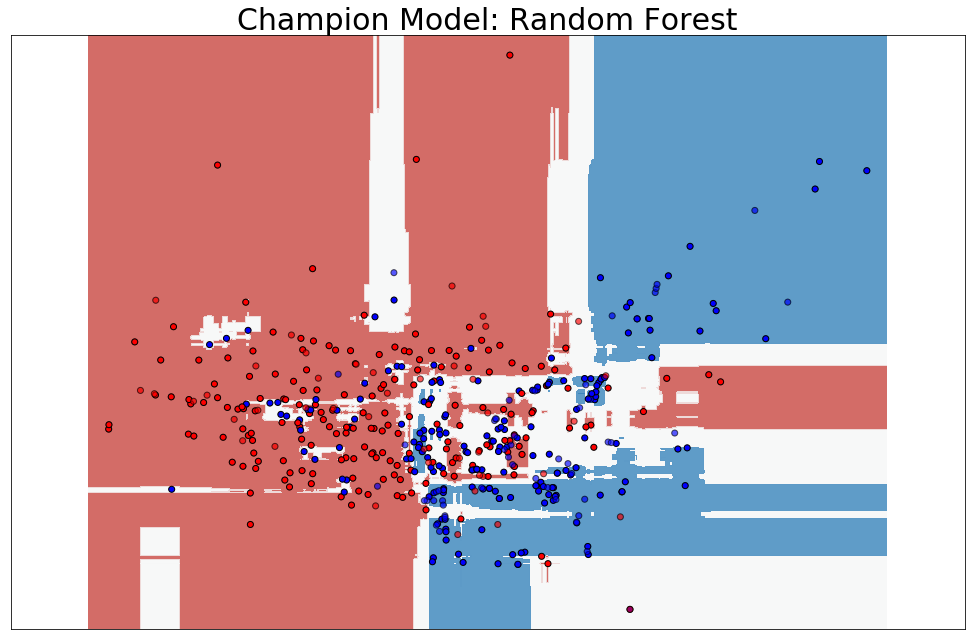

In [58]:
#this runs the Marriage PCA code one time to visualize it

h = .02  # step size in the mesh .02


# names = ["Nearest Neighbors", "Naive Bayes", "Logistic Regression"]

# classifiers = [
#     KNeighborsClassifier(3),

#     GaussianNB(priors = None, var_smoothing = 1e-03),
#     LogisticRegression()
# ]

X = urban_x.copy()
    

X = StandardScaler().fit_transform(X)
pca = PCA(n_components=2) # create a PCA object
pca.fit(X) # do the math
X = pca.transform(X) # get PCA coordinates for scaled_data
 
y = urban_y.adverse_class
    
oversample = SMOTE(random_state = 3) #     ADDED SMOTE
X, y = oversample.fit_resample(X, y)

    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    




names = [ "Random Forest"]


classifiers = [RandomForestClassifier(max_depth= 9, random_state= 5)]


figure = plt.figure(figsize=(27, 9))
i = 1

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

#print(xx.shape)
#print(yy.shape)
# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, len(classifiers) + 1, i)
# if ds_cnt == 0:
#     ax.set_title("Input data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_aspect('equal', 'datalim')

#i += 1

    # iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    
    #score is now weighted percision
    y_pred = clf.predict(X_test)
    score = precision_score(y_test, y_pred, average='weighted')
    
    #print(score)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    #print(Z.shape)
    ax.contourf(xx, yy, Z,levels = 2, cmap=cm, alpha=.8)

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               edgecolors='k', alpha=0.6)
    
    #list_= list(y_df['Unnamed: 0_level_0|FIPS'])
#     for i, txt in enumerate(list_):
#         ax.annotate(txt, (X_train[i, 0], X_train[i, 1]))
        
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    #if ds_cnt == 0:
    ax.set_title('Champion Model: Random Forest', fontsize=30)
   # ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
     #       size=15, horizontalalignment='right')
        
    #plt.savefig('figs/Shooting_PCA_Plot_.png')
    i += 1

plt.tight_layout()
plt.show()
